# Predicting Stock Price Direction Using Machine Learning Techniques

## Navid Ali

### Background 

Stock market trend prediction aims at estimating the future price of stock to enable investors on making informed decisions on their investments. Stock price prediction is a challenging and widely studied problem within a braod range of research sectors including finance, mathematics, computer science, history, and economics. Due to its dynamic, non-statiory, and high volatility, It is impossible to predict stock price with the application of regression models and simple time-sieries. Financial institutions and traders have developed models to try to beat the market, yet rarely has anyone ahcieved higher than average returns on investments. For this reason, the challenge of stcok forecasting continues to appeal among institutions, traders, and researchers; even the slightest improvement of percentages can lead to millions of dollars in profit. 

Some of the well known prediction models continuously researched and optimized include linear and non-linear statistical time series approach such as ARIMA and ARCH. The volatile nature and variance underlying the movement of the stock makes linear models suboptimal and non-linear models have low predictive errors. Machine learning algorithm is another technique that has recently become popular in solving this problem with big data, mathematical and statistical analysis. 

In this project Support Vector Machine (SVM), a machine learning technqiue, will be used to predict the stock price direction for different stocks from technology sector. Our goal is to use SVM at given time t to predict whether the target stock's price will be higher or lower on day t + m. This prediction model approach is a supervised learning binary classification problem where the input parameters are the stock's volatility and momentum.  

In [5]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from pandas_datareader import data as data_reader
import plotly.express as px


In [6]:
## here I was checking every csv file to make sure I had enought data for each 
#stock of interest

df = pd.read_csv('AAPL1.csv')   

df['Date']= pd.to_datetime(df['Date'])
df.index=df['Date']
df = df.drop(['Date'],1)
df.sort_values(by='Date', ascending = True, inplace = True)


df.head()
#df.tail()
df
#df[3370:]
#4320*0.22
#4320-950

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.156786,1.162679,1.117857,1.130179,0.961916,691992000
2005-01-04,1.139107,1.169107,1.124464,1.141786,0.971795,1096810400
2005-01-05,1.151071,1.165179,1.143750,1.151786,0.980306,680433600
2005-01-06,1.154821,1.159107,1.130893,1.152679,0.981066,705555200
2005-01-07,1.160714,1.243393,1.156250,1.236607,1.052499,2227450400
...,...,...,...,...,...,...
2023-04-17,165.089996,165.389999,164.029999,165.229996,165.229996,41516200
2023-04-18,166.100006,167.410004,165.649994,166.470001,166.470001,49923000
2023-04-19,165.800003,168.160004,165.539993,167.630005,167.630005,47720200


In [7]:
# read all the stocks of interest (7 in total) using pandas and adjust the size
# by indicating start and end dates


tickers = ['MSFT1', 'GOOG1', 'AMZN1','AAPL1', 'INTC', 'AMD', 'NVDA']   #given stocks with large volume within ndxt index
start_date = datetime.date(2006, 2, 22)
end_date = datetime.date(2023, 4, 20)
#read in the dataset (csv files)
for ticker in tickers:
    data = data_reader.DataReader(ticker, 'stooq', start_date, end_date)
    data.to_csv(f'{ticker}.csv')
    
data.sort_values(by='Date', ascending = True, inplace = True)  #sort data by datetime in ascending order 


In [8]:
# checking for the datasets size and null values 
# ndxt (tech) sector dataset
 
ndxtdf = pd.read_csv('ndxt.csv')
ndxtdf['Date'] = pd.to_datetime(ndxtdf['Date'])
ndxtdf.index = ndxtdf['Date']
ndxtdf = ndxtdf.drop(['Date'],1)
ndxtdf.sort_values(by = 'Date', ascending = True, inplace = True)

ndxtdf.info()             # find the size of data, dtypes for each parameter
                        # and the non-null values for each column.
ndxtdf = ndxtdf.dropna()   # drop the data with null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2006-02-22 to 2023-04-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4317 non-null   float64
 1   High       4317 non-null   float64
 2   Low        4317 non-null   float64
 3   Close      4317 non-null   float64
 4   Adj Close  4317 non-null   float64
 5   Volume     4317 non-null   float64
dtypes: float64(6)
memory usage: 236.2 KB


In [9]:

ndxtdf  ##because the tech sector starts from 2006-02-22 goes to, 2023-04-20\
#all other stock companies should be customized in size equally.
print(0.22 * len(ndxtdf))
print(len(data))
4320-950   ## = 3370 for 70% train (split index)

949.74
4320


3370

In [10]:
# calculate price volatility array given company
daysAhead = 1
def calcPriceVolatility(numDays, priceArray):
    
    """
    Inputs:
    numDays: number of days from the test data
    priceArray: Closing price (used for y)
    
    Outputs:
    calculated Volatility array for the target stock closing price
    
    """
    global daysAhead
    # make price volatility array
    volatilityArray = []
    movingVolatilityArray = []
    for i in range(1, numDays+1):
        percentChange = 100 * (priceArray[i] - priceArray[i-1]) / priceArray[i-1]
        movingVolatilityArray.append(percentChange)
    volatilityArray.append(np.mean(movingVolatilityArray))
    for i in range(numDays + 1, len(priceArray) - daysAhead):
        del movingVolatilityArray[0]
        percentChange = 100 * (priceArray[i] - priceArray[i-1]) / priceArray[i-1]
        movingVolatilityArray.append(percentChange)
        volatilityArray.append(np.mean(movingVolatilityArray))
    
    return volatilityArray




In [11]:
def calcMomentum(numDays, priceArray):
    """
    Inputs:
    numDays: number of days from the test data
    priceArray: Closing price (used for y)
    
    Outputs:
    calculated momentum array for the target stock closing price
    
    """
    global daysAhead
    # now calculate momentum
    momentumArray = []
    movingMomentumArray = []
    for i in range(1, numDays + 1):
        movingMomentumArray.append(1 if priceArray[i] > priceArray[i-1] else -1)
    momentumArray.append(np.mean(movingMomentumArray))
    for i in range(numDays+1, len(priceArray) - daysAhead):
        del movingMomentumArray[0]
        movingMomentumArray.append(1 if priceArray[i] > priceArray[i-1] else -1)
        momentumArray.append(np.mean(movingMomentumArray))

    return momentumArray
len(calcMomentum(1, data['Close']))
#len(df['Close'])

4318

In [12]:
def makeModelAndPredict(numDays,sectorVolatility, sectorMomentum, splitNumber):
    
    """
    Inputs:
    
    numDays: number days of stock price used for calculating volatility, momentum
    and developing the model
    
    SectorVolatility: The price volatility for the sector dataset (tech) will be
    calculated
    
    SectorMomentum: The momentum of th sector dataset closing price will be 
    calculated using functions with designated formulas.
    
    splitNumber: The index or date at which the test_split will be initialized 
    (~20% test, 80% train)
        
        Returns:
        The SVM model's score, and true/false statement for the direction prediction.
        With this binary classification problem, a -1 will designate to the price
        going down and 1 for a price going up.
    """
    
    global data
    global daysAhead
    
    # get price volatility and momentum for this company
    companyData = data      #AMZN historical data
    companyPrices = list(companyData['Close'])

    volatilityArray = calcPriceVolatility(numDays, companyPrices)
    momentumArray = calcMomentum(numDays, companyPrices)

    splitIndex = (splitNumber - numDays)
    
    # since they are different lengths, find the min length
    if len(volatilityArray) > len(sectorVolatility):
        difference = len(volatilityArray) - len(sectorVolatility)
        del volatilityArray[:difference]
        del momentumArray[:difference]

    elif len(sectorVolatility) > len(volatilityArray):
        difference = len(sectorVolatility) - len(volatilityArray)
        del sectorVolatility[:difference]
        del sectorMomentum[:difference]
    
    # create the feature vectors X
    X = np.transpose(np.array([volatilityArray, momentumArray,\
                               sectorVolatility, sectorMomentum]))
    #print(X)
    # create the feature vectors Y
    Y = []
    for i in range(numDays, len(companyPrices) - daysAhead):
        Y.append(1 if companyPrices[i+daysAhead] > companyPrices[i] else -1)
    #print ("len(Y):",len(Y))

    # fix the length of Y if necessary
    if len(Y) > len(X):
        #print ('fixing length of Y: here2')
        difference = len(Y) - len(X)
        del Y[:difference]

    # split into training and testing sets
    X_train = np.array(X[0:splitIndex]).astype('float64')
    X_test = np.array(X[splitIndex:]).astype('float64')
    y_train = np.array(Y[0:splitIndex]).astype('float64')
    y_test = np.array(Y[splitIndex:]).astype('float64')

    # fit the model and calculate its accuracy
    rbf_svm = svm.SVC(kernel='rbf')
    rbf_svm.fit(X_train, y_train)
    score = rbf_svm.score(X_test, y_test)
    
    #Find and print the actual and predicted direction 
    predicted_direction = rbf_svm.predict(X_test)[0]
    print(rbf_svm.predict(X_test)[0])
    actual_direction = companyPrices[splitIndex] - companyPrices[splitIndex - 1]
    print(companyPrices[splitIndex - 1], companyPrices[splitIndex])
    
    true_pred = False
    
    #Show and store the prediction accuracy with True/Flase statements. 
    if (predicted_direction < 0 and actual_direction < 0) or\
       (predicted_direction > 0 and actual_direction > 0) or\
        (predicted_direction == actual_direction):
        print('Correct direction')
        true_pred = True
        
    else:
        
        print('Wrong direction')
  
    return (score, true_pred)




In [13]:
def main():
    global data

    
    """
    Inputs: nothing new
    Using the above functions for model, and feature calculations, we input the 
    datasets as well as necessary parameters including split_index, stocks, sector
    for X and y in train_test split.
    
    The iteration over n1,n2 for stock and sector are incorporated and looped over
    respectively to return the corresponding mean_prediction accuracy (score).
    The results of prediction efficiancy (true, false), and the model's mean
    score will be stored outside the designated loops within list and dictionaries 
    for further access.
    
    A while loop is used to iterate over the iteration of n1,n2 with 25 combinations
    thus, there will be x number of iterations of 25 n1,n2 with the while loop
    
    """
    # find the list of companies
    permnoList = tickers

    # read the tech sector data and process it
    ndxtdf = pd.read_csv('ndxt.csv')
    ndxtdf['Date'] = pd.to_datetime(ndxtdf['Date'])
    ndxtdf.index = ndxtdf['Date']
    ndxtdf = ndxtdf.drop(['Date'],1)
    ndxtdf.sort_values(by = 'Date', ascending = True, inplace = True)
    ndxtdf = ndxtdf.dropna()
    
    # target prediction array
    ndxtPrices = np.array(ndxtdf['Close'])
    startOfTwelve =  3370                  #split point (index) for train, test 
    
    pred_effic = []       # store the prediction accuracy (True, Flase)
    
    
    while startOfTwelve < 3371:    #1520:  #4559: 3461, 3466, 3476


    # we want to predict where it will be on the next day based on X days previous
        numDaysArray = [5, 10, 20, 90, 270] # day, week, month, quarter, year
        numDaysArrat = np.array(numDaysArray)
        predictionDict = {}
        
    # iterate over combinations of n_1 and n_2 and find prediction accuracies
        for numDayIndex in numDaysArray:
            for numDayStock in numDaysArray:
                ndxtVolatilityArray = calcPriceVolatility(numDayIndex, ndxtPrices)
                ndxtMomentumArray = calcMomentum(numDayIndex, ndxtPrices)
                predictionForGivenNumDaysDict = {}

                for permno in permnoList:

                    #print ("stock:", permno)
                    percentage, true_false = makeModelAndPredict(numDayStock,ndxtVolatilityArray,ndxtMomentumArray,startOfTwelve)
                    predictionForGivenNumDaysDict[permno] = percentage
                    pred_effic.append(true_false)

                predictionAccuracies = list(predictionForGivenNumDaysDict.values())
                meanAccuracy = np.mean(predictionAccuracies)
                print(numDayIndex, numDayStock, meanAccuracy)
                maxIndex = max(predictionForGivenNumDaysDict, key=predictionForGivenNumDaysDict.get)
                maxAccuracy = (maxIndex, predictionForGivenNumDaysDict[maxIndex])
                minIndex = min(predictionForGivenNumDaysDict, key=predictionForGivenNumDaysDict.get)
                minAccuracy = (minIndex, predictionForGivenNumDaysDict[minIndex])
                median = np.median(predictionAccuracies)

    
                numDaysTuple = (numDayIndex, numDayStock)
                predictionDict[numDaysTuple] = {'mean':meanAccuracy, 'max':predictionForGivenNumDaysDict[maxIndex], 'min':predictionForGivenNumDaysDict[minIndex], 'median':median }
    
        sortedTuples = sorted(predictionDict.keys())
        #print(sortedTuples)
        for numDaysTuple in sortedTuples:
            #print ("%s:\t %s\n" % (numDaysTuple, predictionDict[numDaysTuple]))
            sumStats = predictionDict[numDaysTuple]
            print ("& %d & %d & %f & %f & %f & %f \\\\\n" % (numDaysTuple[0], numDaysTuple[1], sumStats['mean'], sumStats['median'], sumStats['max'], sumStats['min']))
    
     
        startOfTwelve += 1
        
    return pred_effic

if __name__ == "__main__": 
    new_var = main()
    

1.0
39.8466 39.0971
Wrong direction
1.0
39.8466 39.0971
Wrong direction
1.0
39.8466 39.0971
Wrong direction
1.0
39.8466 39.0971
Wrong direction
1.0
39.8466 39.0971
Wrong direction
1.0
39.8466 39.0971
Wrong direction
1.0
39.8466 39.0971
Wrong direction
5 5 0.5264270613107822
1.0
40.5959 40.8459
Correct direction
1.0
40.5959 40.8459
Correct direction
1.0
40.5959 40.8459
Correct direction
1.0
40.5959 40.8459
Correct direction
1.0
40.5959 40.8459
Correct direction
1.0
40.5959 40.8459
Correct direction
1.0
40.5959 40.8459
Correct direction
5 10 0.5458377239199157
1.0
36.8738 35.9735
Wrong direction
1.0
36.8738 35.9735
Wrong direction
1.0
36.8738 35.9735
Wrong direction
1.0
36.8738 35.9735
Wrong direction
1.0
36.8738 35.9735
Wrong direction
1.0
36.8738 35.9735
Wrong direction
1.0
36.8738 35.9735
Wrong direction
5 20 0.5268703898840884
1.0
38.8823 37.7741
Wrong direction
1.0
38.8823 37.7741
Wrong direction
1.0
38.8823 37.7741
Wrong direction
1.0
38.8823 37.7741
Wrong direction
1.0
38.8823 37.

175


0.24

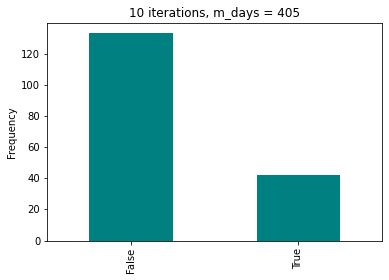

In [17]:
# 1 iterations # MSFT', 'GOOG', 'AMZN','AAPL', 'INTC', 'AMD', 'NVDA


pd.Series(new_var).value_counts().plot.bar(color = ('teal','teal'))
plt.title("10 iterations, m_days = 405")
plt.ylabel("Frequency")

true_ = []
print(len(new_var))
for var in new_var:
    if var == True:
        #print(len(new_var))
        true_.append(var)
        
len(true_)/175

175


0.24

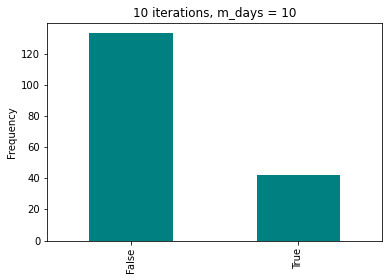

In [18]:
# 10 iterations # MSFT', 'GOOG', 'AMZN','AAPL', 'INTC', 'AMD', 'NVDA
pd.Series(new_var).value_counts().plot.bar(color = ('teal','teal'))
plt.title("10 iterations, m_days = 10")
plt.ylabel("Frequency")

true_ = []
print(len(new_var))
for var in new_var:
    if var == True:
        #print(len(new_var))
        true_.append(var)
        
len(true_)/175

Text(0, 0.5, 'Frequency')

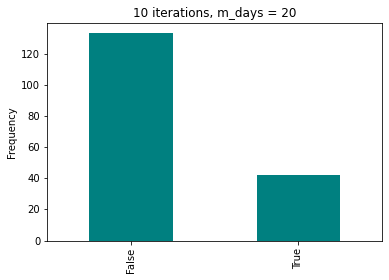

In [19]:
# 10 iterations # MSFT', 'GOOG', 'AMZN','AAPL', 'INTC', 'AMD', 'NVDA
pd.Series(new_var).value_counts().plot.bar(color = ('teal','teal'))
plt.title("10 iterations, m_days = 20")
plt.ylabel("Frequency")

In [20]:
df_result1 = pd.read_excel("svm_results.xlsx", usecols = (0,1,2,3))

In [21]:
df_result = df_result1[:149]  #We only need the data up to m = 270
df_result

,m,n1,n2,mean
0,270,5,5,0.73855
1,270,5,10,0.73971
2,270,5,20,0.73971
3,270,5,90,0.73971
4,270,5,270,0.71030
...,...,...,...,...
144,1,90,270,0.50896
145,1,270,5,0.51100
146,1,270,10,0.52770
147,1,270,20,0.51700


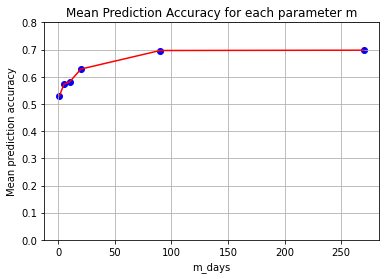

In [22]:
#plot the trend of mean prediction accuracy for each parameter m

x_ax = [1, 5, 10, 20, 90, 270]      # parameter m
y_ax = [0.5296, 0.573, 0.5813, 0.6285, 0.696792, 0.69799052]   # mean accuracy

plt.scatter(x_ax, y_ax, color = 'b')
plt.plot(x_ax, y_ax, color = 'r')
plt.ylim(0, 0.8)
plt.xlabel('m_days')
plt.ylabel('Mean prediction accuracy')
plt.title('Mean Prediction Accuracy for each parameter m')
plt.grid()

In [36]:
# create a bar plot for each m parameter showing mean accuracy for n1,n2


#set the n1,n2 to string to get fixed x_ax labels
df_result = df_result.astype({'n1': str, 'n2':str})


print("Mean Prediction Accuracy for n1,n2, m = 270")

#data for m = 270
m_27msk = df_result['m'] == 270
m_27df = df_result[m_27msk] 

#plot the bar chart
import plotly.express as px
df = m_27df
fig = px.bar(df, x="n1", y="mean",
             color='n2', barmode='group',
             height=400)
fig.show()

Mean Prediction Accuracy for n1,n2, m = 270


In [35]:
# bar plot for m = 90

print("Mean Prediction Accuracy for n1,n2, m = 90")

m_9msk = df_result['m'] == 90
m_9df = df_result[m_9msk]


import plotly.express as px
df = m_9df
fig = px.bar(df, x="n1", y="mean",
             color='n2', barmode='group',
             height=400)
fig.show()

Mean Prediction Accuracy for n1,n2, m = 90


In [34]:
# bar plot for m = 20

print("Mean Prediction Accuracy for n1,n2, m = 20")

m_2msk = df_result['m'] == 20
m_2df = df_result[m_2msk]


import plotly.express as px
df = m_2df
fig = px.bar(df, x="n1", y="mean",
             color='n2', barmode='group',
             height=400)
fig.show()

Mean Prediction Accuracy for n1,n2, m = 20


In [33]:
# bar plot for m = 10

print("Mean Prediction Accuracy for n1,n2, m = 10")

m_1msk = df_result['m'] == 10
m_1df = df_result[m_1msk]


import plotly.express as px
df = m_1df
fig = px.bar(df, x="n1", y="mean",
             color='n2', barmode='group',
             height=400)
fig.show()

Mean Prediction Accuracy for n1,n2, m = 10


In [32]:
# bar plot for m = 5
print("Mean Prediction Accuracy for n1,n2, m = 5")

m_msk = df_result['m'] == 5
m_df = df_result[m_msk]


import plotly.express as px
df = m_df
fig = px.bar(df, x="n1", y="mean",
             color='n2', barmode='group',
             height=400)
fig.show()

Mean Prediction Accuracy for n1,n2, m = 5


In [31]:
# bar plot for m = 1
print("Mean Prediction Accuracy for n1,n2, m = 1")
m_0msk = df_result['m'] == 1
m_0df = df_result[m_0msk]


import plotly.express as px
df = m_0df
fig = px.bar(df, x="n1", y="mean",
             color='n2', barmode='group',
             height=400)
fig.show()

Mean Prediction Accuracy for n1,n2, m = 1


#### citations:

```
https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf

https://finance.yahoo.com/quote/AAPL/history?period1=1104537600&period2=1682294400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

https://plotly.com/python/

```
